In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,random_split
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
### only use one stations
# Read in data and display first 5 rows
fn='../Data/INTERP_CTU.csv'
features = pd.read_csv(fn)
features.head()

,utvec,dv,err,temp,SM_EWT,date
0,2012.847412,0.0549,0.1532,5.38669,0.473216,2012-11-06
1,2012.850098,0.0442,0.1524,5.34453,0.474801,2012-11-07
2,2012.852783,0.0276,0.1514,5.23883,0.476454,2012-11-08
3,2012.855591,0.0165,0.1503,5.00576,0.478027,2012-11-09
4,2012.858276,0.0112,0.1500,4.65426,0.479654,2012-11-10


In [5]:
time=np.asarray(features.utvec)
dv = np.asarray(features.dv) 
dv = dv / np.max(np.abs(dv))

temperature = np.asarray(features.temp)
temperature = temperature - np.mean(temperature)
temperature = temperature / np.max(temperature)

soil_moisture = np.asarray(features.SM_EWT)
#soil_moisture = 0.5 * dv + 0.2 * temperature +  2 * soil_moisture
soil_moisture = soil_moisture - np.mean(soil_moisture)
soil_moisture = soil_moisture / np.max(soil_moisture)

(3572,) (3572,) (3572,)


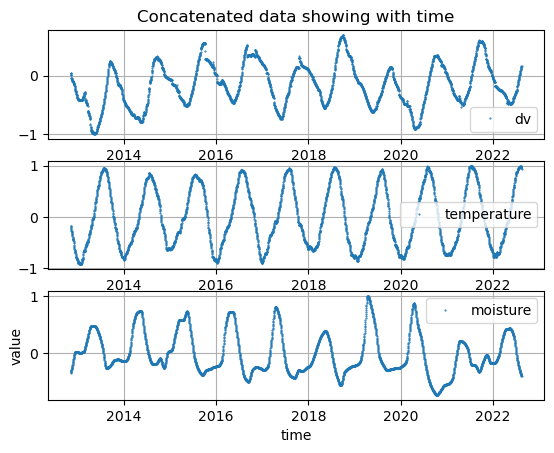

In [6]:
print(dv.shape, temperature.shape, soil_moisture.shape)
fig, ax = plt.subplots(3,1)
ax[0].set_title("Concatenated data showing with time")
# Plot the true vs predicted soil moisture values
ax[0].plot(time, dv, label='dv', ls="", marker='.', markersize=1)
ax[1].plot(time , temperature, label='temperature', ls="", marker='.', markersize=1)
ax[2].plot(time , soil_moisture, label='moisture', ls="", marker='.', markersize=1)
plt.xlabel('time')
plt.ylabel('value')
ax[0].legend();ax[1].legend();ax[2].legend();
ax[0].grid(True);ax[1].grid(True);ax[2].grid(True);
plt.show()


In [7]:
from numpy import hstack,column_stack

X = column_stack((dv, temperature, soil_moisture))
# Standardize input features and target variable
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)


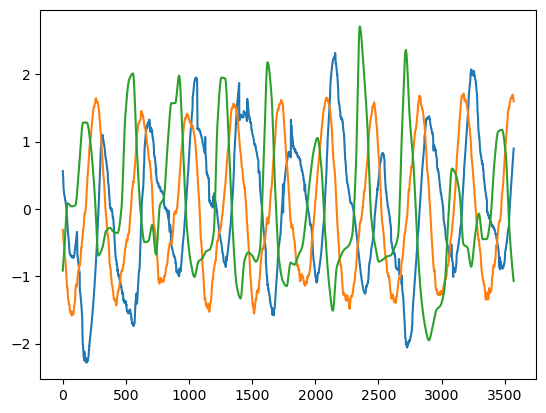

In [8]:
# check after applying scaler
plt.plot(X)

In [9]:
# train-test split for time series
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
#train, test = X[:train_size], X[train_size:]
test, train = X[:test_size], X[test_size:]
print(train.shape, test.shape)

(2393, 3) (1179, 3)


In [10]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset 
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    print(dataset.shape)
    FX, Fy = [], []
    for i in range(lookback, len(dataset)-lookback):
        feat1 = dataset[i-lookback : i, 0]
        feat2 = dataset[i-lookback : i, 1]
        feat = column_stack((feat1,feat2))
        
        target = dataset[i, 2].reshape(1)
        FX.append(feat)
        Fy.append(target)
        
        #print(i,i+lookback, FX,Fy)
        #print(i,i+lookback,  feat.shape, Fy[i].reshape(len(Fy[i]),1).shape)

    return torch.tensor(FX), torch.tensor(Fy)

In [11]:
lookback = 120
X_train, y_train = create_dataset(train , lookback=lookback)
X_test,  y_test  = create_dataset(test  , lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2393, 3)
(1179, 3)
torch.Size([2153, 120, 2]) torch.Size([2153, 1])
torch.Size([939, 120, 2]) torch.Size([939, 1])


/var/folders/zj/xxy_mn8d3jx2gfm5j907g72r0000gn/T/ipykernel_19581/1660405786.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(FX), torch.tensor(Fy)


In [12]:
print(X_train.detach().numpy().shape)

(2153, 120, 2)


In [13]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTM, self).__init__()

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through the LSTM layer
        lstm_out, _ = self.lstm(x)

        # Take the output from the last time step
        last_output = lstm_out[:, -1, :]

        # Forward pass through the output layer
        output = self.linear(last_output)

        return output

In [14]:
# directory path for save checkpoint
dir1="./"
checkpoint_path = dir1+'/checkpoint.pt'

In [15]:
select_batch_size = lookback
train_loader = DataLoader( TensorDataset(X_train, y_train), shuffle=True, batch_size=select_batch_size)
#test_loader =  DataLoader( TensorDataset(X_test,  y_test ), shuffle=True, batch_size=select_batch_size)
print(train_loader)

In [16]:
#for X_batch, y_batch in train_loader:
#    for i in range(len(X_batch)):
#        plt.plot(i, X_batch.numpy()[:,0,0])

Epoch 0/40: train RMSE 1.0051, test RMSE 1.0539
Epoch 2/40: train RMSE 0.9974, test RMSE 1.0536
Epoch 4/40: train RMSE 0.7514, test RMSE 0.8723
Epoch 6/40: train RMSE 0.6388, test RMSE 0.6774
Epoch 8/40: train RMSE 0.6106, test RMSE 0.6058
Epoch 10/40: train RMSE 0.5726, test RMSE 0.5934
Epoch 12/40: train RMSE 0.5250, test RMSE 0.5452
Epoch 14/40: train RMSE 0.4889, test RMSE 0.4839
Epoch 16/40: train RMSE 0.4762, test RMSE 0.4888
Epoch 18/40: train RMSE 0.4579, test RMSE 0.4523
Epoch 20/40: train RMSE 0.4498, test RMSE 0.4662
Epoch 22/40: train RMSE 0.4408, test RMSE 0.4812
Epoch 24/40: train RMSE 0.4305, test RMSE 0.4619
Epoch 26/40: train RMSE 0.4218, test RMSE 0.4760
Epoch 28/40: train RMSE 0.4134, test RMSE 0.4831
Epoch 30/40: train RMSE 0.4217, test RMSE 0.4914
Epoch 32/40: train RMSE 0.4127, test RMSE 0.4990
Epoch 34/40: train RMSE 0.3994, test RMSE 0.5537
Epoch 36/40: train RMSE 0.3950, test RMSE 0.5652
Epoch 38/40: train RMSE 0.3872, test RMSE 0.5727


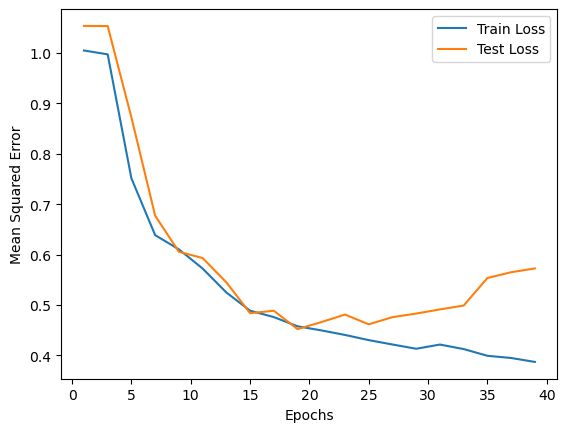

In [17]:

# learning_rate
learning_rate=0.0005
# Example usage
input_size = 2      # Number of features in the input time series
hidden_size = 16    # Number of hidden units in the LSTM layer
num_layers = 6      # Number of LSTM layers
output_size = 1     # Number of features in the output time series

# Create an instance of the model
model = MultivariateLSTM(input_size, hidden_size, num_layers, output_size)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store training history
train_loss_history = []
test_loss_history = []
# Lists to store iteration or epoch numbers
epochs_list = []

# Generate predictions for the next num_predictions time steps
#predictions = []
# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        
        y_pred = model(X_batch.float())
        loss = criterion(y_pred, y_batch.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation
    if epoch % 2 != 0:
        continue
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.float())
        train_rmse = np.sqrt(criterion(y_pred, y_train.float()))
        
        y_pred = model(X_test.float())
        test_rmse = np.sqrt(criterion(y_pred, y_test.float()))
        ## Save the prediction
        #predictions.append(y_pred.squeeze().tolist())
        
    train_loss_history.append(train_rmse)
    test_loss_history.append(test_rmse)
    epochs_list.append(epoch + 1)
    print("Epoch %d/%d: train RMSE %.4f, test RMSE %.4f" % (epoch,num_epochs, train_rmse, test_rmse))
    #print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_rmse:.4f} | Test Loss: {test_rmse:.4f}')

    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
                    }

    #checkpoint_path = f'{dir1}model_checkpoint_epoch_{epoch}.pth'
    torch.save( checkpoint, checkpoint_path)
    
        
# Plot the loss over epochs
plt.plot(epochs_list, train_loss_history, label='Train Loss')
plt.plot(epochs_list, test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

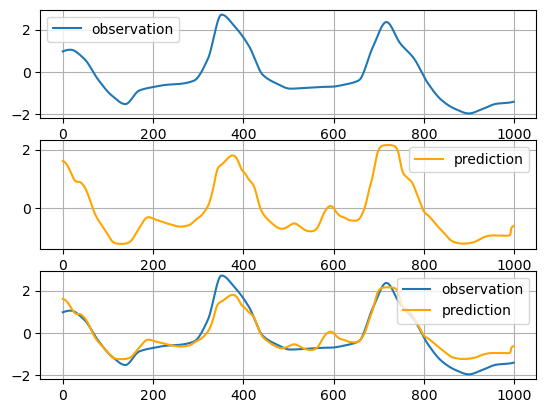

In [18]:
## test model

# Create an instance of the model
#model = MultivariateLSTM(input_size, hidden_size, num_layers, output_size)

sequence_length = lookback
#time_point= 20

output2=[]
for time_point in range(2000,3000):
    # Convert your input data to a torch tensor if it's not already
    input_data = torch.tensor(X[time_point-sequence_length:time_point,:2], dtype=torch.float32).unsqueeze(0)
    # Forward pass
    output = model(input_data)
    #print(output.detach().numpy().item())
    output2.append(output.detach().numpy().item())

fig, ax = plt.subplots(3,1)
ax[0].plot(X[2000:3000 ,2],label='observation')
ax[1].plot(output2,label='prediction',c='orange')
ax[2].plot(X[2000:3000 ,2],label='observation')
ax[2].plot(output2,label='prediction',c='orange')
ax[0].legend();ax[1].legend();ax[2].legend();
ax[0].grid(True);ax[1].grid(True);ax[2].grid(True);

Test model with data from other station

In [49]:
### only use one stations
# Read in data and display first 5 rows
fn='../Data/INTERP_FORU.csv'
features = pd.read_csv(fn)
features.head()

,utvec,dv,err,temp,SM_EWT,date
0,2016.929443,0.1990,0.1465,1.072340,0.249933,2016-12-06
1,2016.932251,0.1928,0.1458,0.742881,0.250444,2016-12-07
2,2016.934937,0.1883,0.1452,0.330317,0.250970,2016-12-08
3,2016.937744,0.1784,0.1443,0.072685,0.251465,2016-12-09
4,2016.940430,0.1782,0.1437,-0.030240,0.251949,2016-12-10


In [50]:
time=np.asarray(features.utvec)
dv = np.asarray(features.dv) 
dv = dv / np.max(np.abs(dv))

temperature = np.asarray(features.temp)
temperature = temperature - np.mean(temperature)
temperature = temperature / np.max(temperature)

soil_moisture = np.asarray(features.SM_EWT)
soil_moisture = soil_moisture - np.mean(soil_moisture)
soil_moisture = soil_moisture / np.max(soil_moisture)

(2081,) (2081,) (2081,)


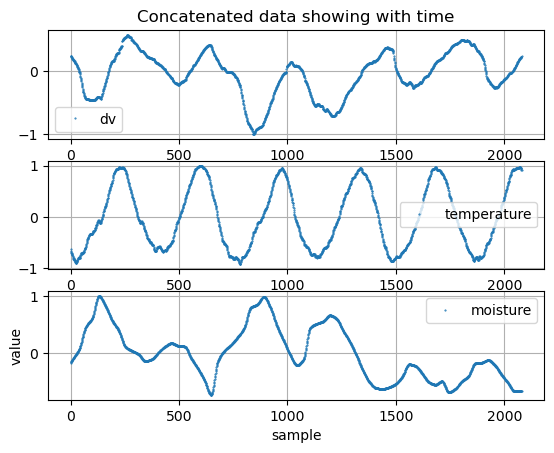

In [51]:
print(dv.shape, temperature.shape, soil_moisture.shape)
fig, ax = plt.subplots(3,1)
ax[0].set_title("Concatenated data showing with time")
# Plot the true vs predicted soil moisture values
ax[0].plot( dv, label='dv', ls="", marker='.', markersize=1)
ax[1].plot( temperature, label='temperature', ls="", marker='.', markersize=1)
ax[2].plot( soil_moisture, label='moisture', ls="", marker='.', markersize=1)
plt.xlabel('sample')
plt.ylabel('value')
ax[0].legend();ax[1].legend();ax[2].legend();
ax[0].grid(True);ax[1].grid(True);ax[2].grid(True);
plt.show()


In [52]:
from numpy import hstack,column_stack

X2 = column_stack((dv, temperature, soil_moisture))
# Standardize input features and target variable
scaler_X2 = StandardScaler()
X2 = scaler_X2.fit_transform(X2)


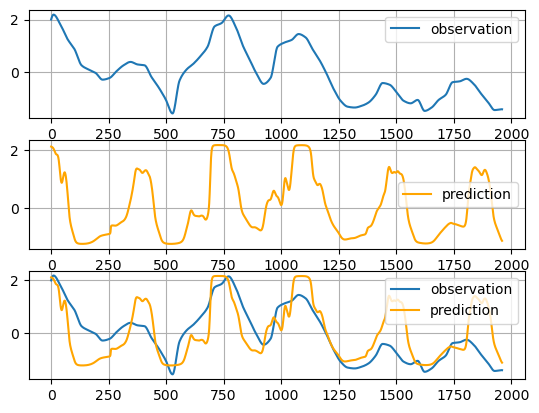

In [53]:
## test model
sequence_length = lookback

output2=[]
for time_point in range(sequence_length, len(X2)):
    # Convert your input data to a torch tensor if it's not already
    input_data = torch.tensor(X2[time_point-sequence_length:time_point,:2], dtype=torch.float32).unsqueeze(0)
    # Forward pass
    output = model(input_data)
    #print(output.detach().numpy().item())
    output2.append(output.detach().numpy().item())

fig, ax = plt.subplots(3,1)
ax[0].plot(X2[sequence_length: ,2],label='observation')
ax[1].plot(output2,label='prediction',c='orange')
ax[2].plot(X2[sequence_length: ,2],label='observation')
ax[2].plot(output2,label='prediction',c='orange')
ax[0].legend();ax[1].legend();ax[2].legend();
ax[0].grid(True);ax[1].grid(True);ax[2].grid(True);